# 4 Theory

In [1]:
# imports
import json
import pandas as pd
from sklearn.cluster import k_means
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
df = pd.read_csv("new_clean_data.csv")

## Clustering analysis

This section will explain and show how K-means clustering is performed on the data set. From the introductory analysis seen in part 1, it became evident that the distribution of all factors are not directly correlated to total amount of incidents happening. Therefore, it could be interesting to locate the most central points where these other factors are peaking. This kind  of knowledge could be utilized to target specfic types of incidents in the places where it would the greatest effect. And the same methodology could be applied on many different kinds of factors and/or vehicle types that cannot easily be identified.

In [3]:
#filter the data
slippery_related = df[df["contributing factor vehicle 1"] == "Pavement Slippery"]

In [4]:
#picking the location columns
X = slippery_related[["lon","lat"]]

# list for holding the labels for the different ks
all_data = X.copy()
all_labels = []
centroids_df = pd.DataFrame()
all_centroids = {}
all_inertia = []

# run kmeans 5 times with k = 2..6
for k in xrange(2,7):
    centroids, labels, inertia = k_means(X, n_clusters=k) # inertia is the sum of squared errors for the model
    all_data["k{}".format(k)] = labels
    all_labels.append(labels)
    all_inertia.append(inertia)
    all_centroids["k{}".format(k)] = [(x,y) for x,y in centroids]

The method known as the *Elbow Method* is used to decide the best number of clusters. Below is the inertia plottied against the value of `k`. This value is a measure of the closest distance a point has to one of the `k`-centers. The place where the line flattens the most is a good basis for a value of `k`. In this, that would be 4 or 5.

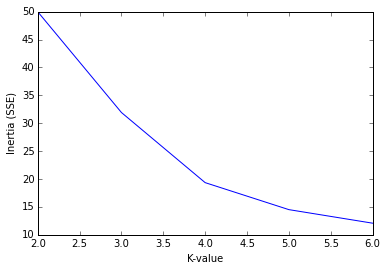

In [5]:
plt.tight_layout
plt.ylabel("Inertia (SSE)")
plt.xlabel("K-value")
plt.plot(np.arange(2,7,1), all_inertia)
plt.show()

In [6]:
# save the geodata as csv
all_data.to_csv("slippery_geodata_with_ks.csv", index=False)

# and the centroids as json
with open('slippery_centroids.json', 'w') as file:
    json.dump(all_centroids, file)

## Regression analysis

In this section two different kinds of regression will be performed, RandomForestRegressor and MLPRegressor. RandomForestRegressor is a decision tree based regression algorithm used to estimate continouos values. The MLPRegressos is a multi layer perceptron (more commonly known as a neural network) based regressor. Two different models are used to form a basis for comparison.

In preparation for the analyses, the data is filtered and processed to the right format. First, several features of the data set were chosen. For both analyses `["borough", "year", "month", "weekday", "hour"]` which all can be considered as categorical features. Second, the data was grouped to get an hourly count of the accidents in each borough for every date (both year, month, and weekday) in data set. Third, the features were converted using pandas `get_dummies()` that converts them into numerical indicator values. As oppposed to e.g. one hot encoding this ensures no hierachy among the values of the different features and instead new boolean dummy variables are created.

Before applying the regressors, the data was split into a training and a test part to avoid overfitting the data. Additionally, the `SelectFromModel` model from the `sklearn.feature_selection` library was applied to `RandomForesRegressor` to see if any improvements could be achieved. This model selects the most important features based on the a model's `feature_importances_` that tells how much a feature in the input says about the predicted output.

To measure the performance of the regressors, crossvalidation was utilized to gain a more robust measure of the performance of each regressor. The performance for each of the regressors were measured by $R^2$ number. Different versions of this measurer exist, but in `scikit`-version, which is used for this task, it is defined as $1-\frac{u}{v}$, where $u = \sum((y_{true}-y_{pred})^2)$ and $v = \sum((y_{true}-\mu_{y_{true}})^2)$, which in simpler terms is a measure of how much the predicted values vary from the true values compared to how much the true values vary from the mean of the true values.

Lastly, the predicted values of each regressor were inspected visually by their residual plots, because it can be a bit hard to interpret $R^2$ by itself, and plotting the data displays how the regressors estimate.

The reasen for choosing regression was to be able to predict numerical numbers and the choice of using these two specificially was to try something novel. One can imagine that predicting the amount of accidents on an hourly level in every borough could be a huge benefit e.g. to schedule manpower in the different police precints. The model made here is rather simple, but could easily be expandend upon with e.g. access to weather data. 

The results can be seen below all the code.

## Data Preparation
This subsection is most explained by inline comments. The $R^2$ values are right after each regressor code block and will also be summarized in the end.

In [7]:
# grouping by the features we are interested in and getting their sizes
simple_series = df.groupby(["borough", "year", "month", "weekday", "hour"]).size()

# turn the series into a data frame
simple_df = pd.DataFrame(simple_series)

# save data frame to csv and load it agagin 
# (a workaround - I did not know have to directly 
# put the features that I grouped by into every row)
simple_df.to_csv("test.csv")
new_simple_df = pd.read_csv("test.csv")

# label the columns again and the new "count" column created by size()
new_simple_df.columns = ["borough", "year", "month", "weekday", "hour", "count"]

# transform the categorial values into numerical values
columns_to_transform = ["borough", "year", "month", "weekday", "hour"]
new_simple_df_with_dummies = pd.get_dummies(new_simple_df, columns = columns_to_transform )

## RandomForestRegressor

In [ ]:
# random forest regressor without SelectFromModel feature selection

X = new_simple_df_with_dummies.drop("count", 1)
y = new_simple_df["count"]

# split the data and target for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfg = RandomForestRegressor(n_estimators=100)
rfg = rfg.fit(X_train, y_train)

scores = cross_val_score(rfg, X_test, y_test, cv=5)

print("R-squared: {:.2f}".format(sum(scores)/5))

R-squared: 0.83


In [ ]:
# random forest regressor with SelectFromModel feature selection

X = new_simple_df_with_dummies.drop("count", 1)
y = new_simple_df["count"]

# split the data and target for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# create random forest regressor with 100 estimators
rfg_sfm = RandomForestRegressor(n_estimators=100)

# create a SelectFromModel to choose the most important features from data
sfm = SelectFromModel(rfg_sfm, threshold=0.001)
sfm.fit(X, y)

new_X = sfm.transform(X)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

rfg_sfm.fit(X_train, y_train)

scores = cross_val_score(rfg_sfm, X_test, y_test, cv=5)

print("R-squared: {:.2f}".format(sum(scores)/5))

## MLPRegressor

In [ ]:
# MLP regressor

X = new_simple_df_with_dummies.drop("count", 1)
y = new_simple_df["count"]

# split the data and target for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a MLP regressor
mlp_reg = MLPRegressor(random_state=42)

# fit the regressor
mlp_reg.fit(X_train, y_train)

scores = cross_val_score(mlp_reg, X_test, y_test, cv=5)

print("R-squared: {:.2f}".format(sum(scores)/5))

## The residual plots of the regressions

In [ ]:
# data for the scatter plots
rfg_predicted = rfg_sfm.predict(X_test)
mlp_predicted = mlp_reg.predict(X_test)

plt.style.use('ggplot')

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

ax1.set_title('RandomForestRegressor')
ax2.set_title('MLPRegressor')

ax1.scatter(y_test, rfg_predicted)
ax2.scatter(y_test, mlp_predicted)

# numbers to prodcue an identity line
t = np.arange(0., 78, 1)

# red identity line
ax1.plot(t, t, 'r--')
ax2.plot(t, t, 'r--')

# set axes limits
ax1.set_xlim([-5, 75])
ax1.set_ylim([-5, 75])
ax2.set_xlim([-5, 75])

# set axes labels by setting text on the figure
f.text(0.5, 0.00, 'Actual', ha='center', va='center')
f.text(0.00, 0.5, 'Predicted', ha='center', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

## Results

The $R^2$ yielded a score of $0.82$ for the `RandomForestRegressor` both with and without the use of the `SelectFromModel`. The results seems pretty good the this. One could argue that a lot of other variables have a huge influence on the number of accidents on an hourly basis besides the ones chosen in this case. However, it was also a bit surprising it did not improve the score of removing any of the features using the `SelectFromModel`.

Th `MLPRegressor` yielded an $R^2$ score of $0.84$, thereby a tiny bit better than the `RandomForestRegressor`. From the residual plot it can acutally be seen visually, or a least it seems so, that `MLPRegressor` performed best. The points are located more densely around the red line, that indicates a perfect prediction, and also seems better guessing the higher values in general. However, it also evident that it sometimes predict a negative amount which can obviously never be the case. The `MLPRegressor` can be tweaked a lot, and it would be very interesting to work more on this, especially with more features.